In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

from sklearn.datasets import load_iris, fetch_kddcup99, fetch_openml
import pandas as pd

In [2]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
indexes = np.arange(100)
indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [5]:
import random

In [6]:
def sample_bag(indexes, max_samples):
    n_samp = int(max_samples*len(indexes))
    return(random.choices(indexes, k=n_samp))

In [7]:
n_estimators = 4
max_samples = 0.6

bags_indexes = [sample_bag(indexes, 0.05) for _ in range(n_estimators)]
bags_indexes

[[83, 17, 19, 96, 77],
 [65, 22, 12, 63, 57],
 [33, 42, 34, 91, 75],
 [11, 4, 47, 2, 68]]

In [8]:
estimators = [GaussianMixture().fit(data.x_train[indx]) for indx in bags_indexes]
estimators
    

[GaussianMixture(), GaussianMixture(), GaussianMixture(), GaussianMixture()]

In [9]:

from sklearn.ensemble import IsolationForest

In [10]:


bags_indexes = [sample_bag(indexes, 0.05) for _ in range(n_estimators)]
estimators = [GaussianMixture().fit(data.x_train[indx]) for indx in bags_indexes]
for est, bag_idx in zip(estimators, bags_indexes):
    oob_idxs = np.setxor1d(indexes, bag_idx)
    oob_points = data.x_train[oob_idxs]
    for p in oob_points:
        error = IsolationForest().fit(est.sample(100)[0]).predict(np.array([p]))

    break

In [11]:
error

array([-1])

In [12]:
for est, bag_idx in zip(estimators, bags_indexes):
    oob_idxs = np.setxor1d(indexes, bag_idx)
    oob_points = data.x_train[oob_idxs]
    print(est.predict(oob_points))
    break

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
for est, bag_idx in zip(estimators, bags_indexes):
    oob_idxs = np.setxor1d(indexes, bag_idx)
    oob_points = data.x_train[oob_idxs]
    ad = IsolationForest().fit(oob_points)
    test_pt = est.sample(1)
    ad_pred = ad.predict(test_pt[0])
    print(ad_pred)
    print(test_pt)
#    print(est.predict([oob_p]))
    break
#    est.predict()

[1]
(array([[6.81251369, 3.21190215, 5.61958545, 2.02263241]]), array([0]))


In [14]:
%%timeit
sample_bag(indexes, 40)

1.06 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
from tqdm import tqdm

In [16]:

def compute_data_oob_generative(
    u: Utility,
    n_est: int = 10,
    max_samples: float = 0.8,
    progress=False
) -> ValuationResult:
    r"""
    """

    result: ValuationResult[np.int_, np.float_] = ValuationResult.empty(
        algorithm="data_oob", indices=u.data.indices, data_names=u.data.data_names
    )
    bags_indexes = [sample_bag(u.data.indices, max_samples) for _ in range(n_est)]
    
    if(progress):
        estimators_AD = [IsolationForest().fit(data.x_train[indx]) for indx in tqdm(bags_indexes)]
    else:
        estimators_AD = [IsolationForest().fit(data.x_train[indx]) for indx in bags_indexes]

    

    for est, bag_idx in zip(estimators_AD, bags_indexes):
        oob_idx = np.setxor1d(u.data.indices, bag_idx)
        array_loss = est.predict(data.x_train[oob_idx])
        result += ValuationResult(
            algorithm="data_oob",
            indices=oob_idx,
            values=array_loss,
            counts=np.ones_like(array_loss, dtype=u.data.indices.dtype),
        )

    return result
    

In [17]:
Utility(GaussianMixture(), data, Scorer('accuracy', default=0.0))
#Utility(model, data, Scorer("accuracy", default=0.0))

In [18]:
    
def compute_data_oob_generative_2(
    u: Utility,
    n_est: int = 10,
    max_samples: float = 0.8,
    progress=False
) -> ValuationResult:
    r"""
    """

    result: ValuationResult[np.int_, np.float_] = ValuationResult.empty(
        algorithm="data_oob", indices=u.data.indices, data_names=u.data.data_names
    )
    bags_indexes = [sample_bag(u.data.indices, max_samples) for _ in range(n_est)]
    
    if(progress):
        if "synthcity" in str(type(u.model)):
            estimators = [u.model.fit(GenericDataLoader(data.x_train[indx])) for indx in tqdm(bags_indexes)]    
        else:
            estimators = [u.model().fit(data.x_train[indx]) for indx in tqdm(bags_indexes)]    
    else:
        if "synthcity" in str(type(u.model)):
            estimators = [u.model.fit(GenericDataLoader(data.x_train[indx])) for indx in bags_indexes]    
        else:
            estimators = [u.model().fit(data.x_train[indx]) for indx in bags_indexes]    
        #estimators = [GaussianMixture().fit(data.x_train[indx]) for indx in bags_indexes]    

    for est, bag_idx in tqdm(zip(estimators, bags_indexes)):
        oob_idx = np.setxor1d(u.data.indices, bag_idx)
        generated_data = est.sample(200)[0]
        ad = IsolationForest().fit(generated_data)
        array_loss = np.array([ad.predict(np.array([u.data.x_train[p]]))[0] for p in oob_idx])
        
        result += ValuationResult(
            algorithm="data_oob",
            indices=oob_idx,
            values=array_loss,
            counts=np.ones_like(array_loss, dtype=u.data.indices.dtype),
        )

    return result
    

In [32]:
    
def compute_data_oob_generative_3(
    u: Utility,
    n_est: int = 10,
    max_samples: float = 0.8,
    progress=False
) -> ValuationResult:
    r"""
    """

    result: ValuationResult[np.int_, np.float_] = ValuationResult.empty(
        algorithm="data_oob", indices=u.data.indices, data_names=u.data.data_names
    )

    if(progress): iterator = tqdm(range(n_est))
    else: iterator = range(n_est)
    for _ in iterator:
        bag_idx = sample_bag(u.data.indices, max_samples)
        if "synthcity" in str(type(u.model)):
            est = u.model.fit(GenericDataLoader(data.x_train[bag_idx]))
        else:
            est = u.model().fit(data.x_train[bag_idxx])
        oob_idx = np.setxor1d(u.data.indices, bag_idx)
        if "synthcity" in str(type(u.model)):
            generated_data = est.generate(count=20).dataframe()
        else:
            generated_data = est.sample(200)[0]
        ad = IsolationForest().fit(generated_data)
        array_loss = np.array([ad.predict(np.array([u.data.x_train[p]]))[0] for p in oob_idx])
        result += ValuationResult(
            algorithm="data_oob",
            indices=oob_idx,
            values=array_loss,
            counts=np.ones_like(array_loss, dtype=u.data.indices.dtype),
        )
        
    return result
    

In [33]:

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader

In [34]:


#model = KNeighborsClassifier(n_neighbors=5)
#model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
model = GaussianMixture
model = Plugins().get("ctgan")

utility = Utility(model, data, Scorer("accuracy", default=0.0))

[2023-09-22T17:40:15.153469+0200][61208][CRITICAL] module disabled: /home/bastienzim/Documents/pyDVL_DataOOB/venv/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-09-22T17:40:15.156659+0200][61208][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-09-22T17:40:15.158817+0200][61208][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-09-22T17:40:15.160726+0200][61208][CRITICAL] module plugin_great load failed


In [35]:
oob_values = compute_data_oob_generative_3(utility, progress=True, max_samples=0.5, n_est=5)

100%|██████████| 5/5 [05:17<00:00, 63.51s/it]


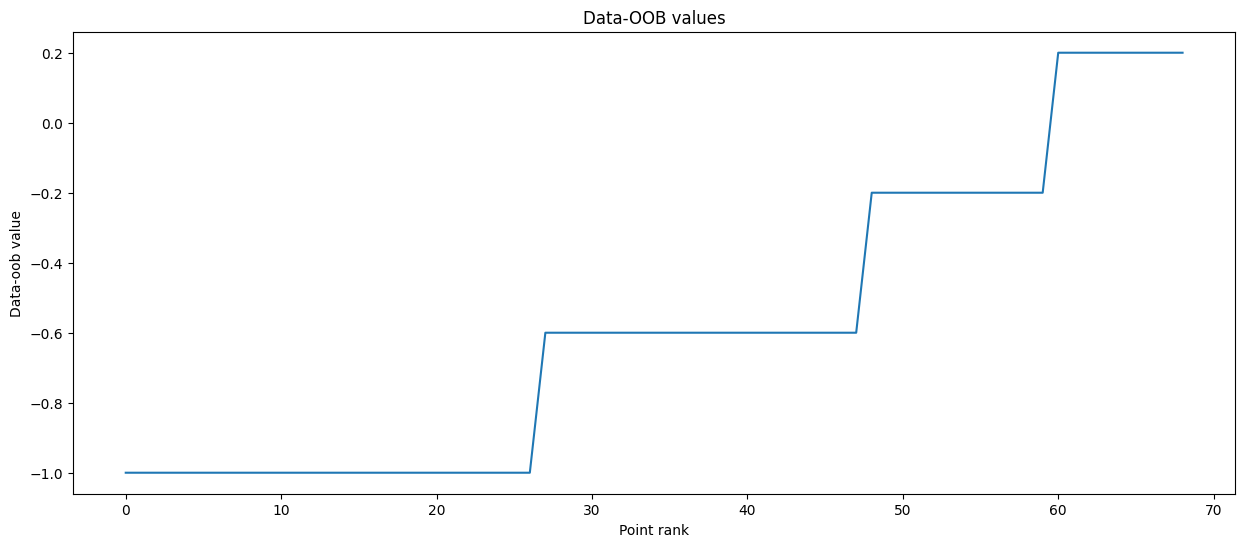

In [36]:
oob_values.sort(key="value")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])

ax.plot(np.arange(len(oob_values.values)), oob_values.values)
ax.set_title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

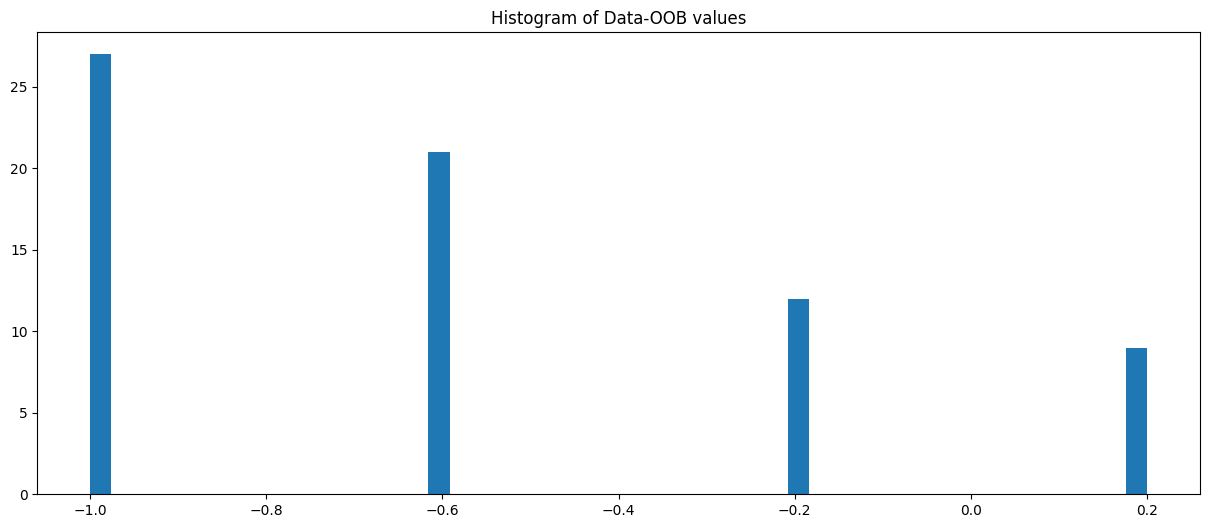

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])
ax.hist(oob_values.values, bins=50)
ax.set_title("Histogram of Data-OOB values");

In [38]:
utility.data.x_train[:,1].shape, oob_values.values.shape

((120,), (69,))

In [44]:
oob_values.to_dataframe()["data_oob"]

119   -1.0
49    -1.0
71    -1.0
72    -1.0
44    -1.0
      ... 
27     0.2
106    0.2
51     0.2
113    0.2
20     0.2
Name: data_oob, Length: 69, dtype: float64

In [46]:
df = pd.DataFrame(utility.data.x_train, columns=utility.data.feature_names)
df.loc[:,"values"] = oob_values.to_dataframe()["data_oob"]
df.loc[:,"values"].fillna(1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),values
0,5.2,3.5,1.5,0.2,NaN
1,5.0,3.4,1.6,0.4,NaN
2,6.8,3.2,5.9,2.3,-0.6
3,5.1,3.3,1.7,0.5,-1.0
4,6.4,2.8,5.6,2.2,-0.2
...,...,...,...,...,...
115,4.8,3.1,1.6,0.2,NaN
116,6.2,2.9,4.3,1.3,NaN
117,4.9,3.6,1.4,0.1,NaN
118,4.4,2.9,1.4,0.2,-0.6


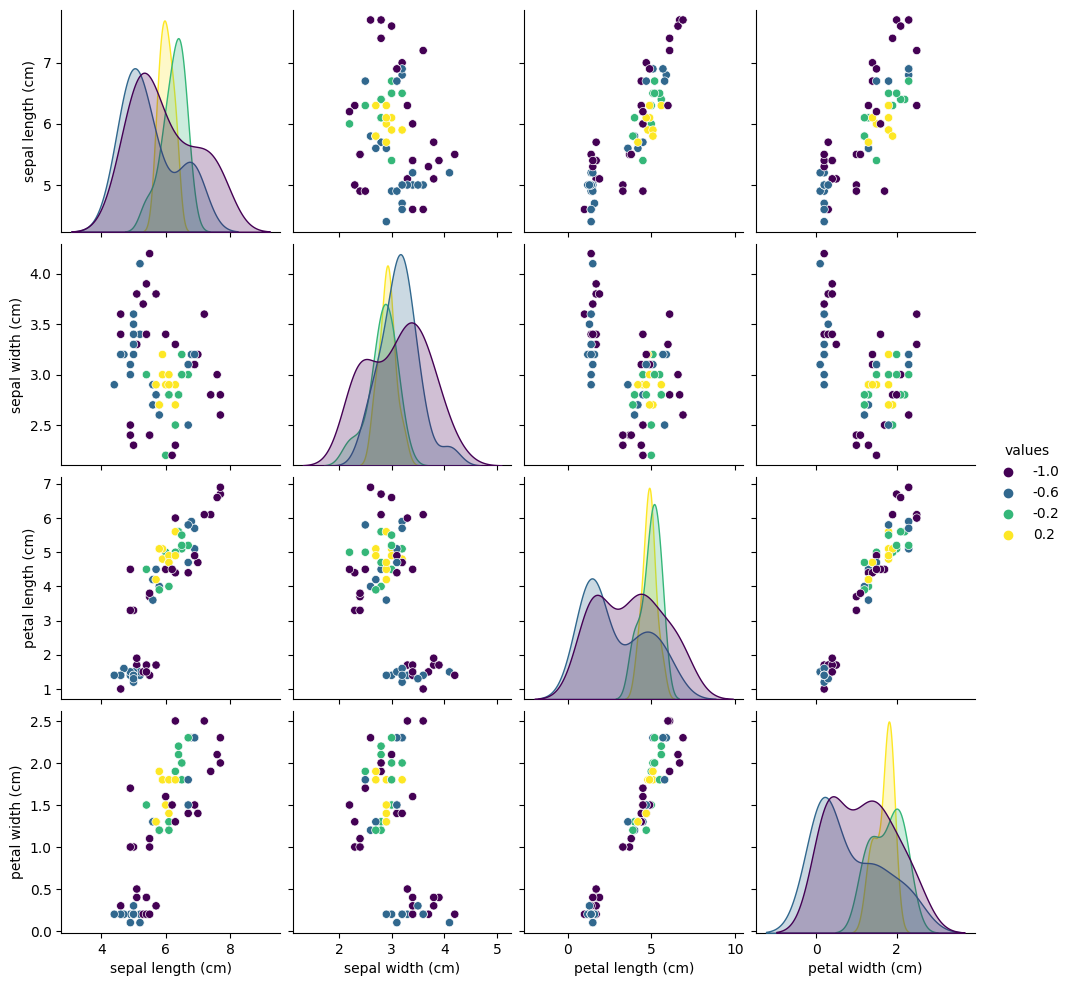

In [47]:
sns.pairplot(data=df, hue="values", palette="viridis")

In [48]:
sns.scatterplot(x = utility.data.x_train[:,2], y=utility.data.x_train[:,1], hue =[x if x<-0.1 else 1 for x in oob_values.values], palette='plasma')

ValueError: All arrays must be of the same length

## Variance

The variance it the weak learner variance. It is computed with Welford's online algorithm.

In [ ]:
plot_list = [(a, b) for a, b in zip(oob_values.values, oob_values.variances)]
plot_list = pd.DataFrame(plot_list).sample(100).sort_values(by=0).values
yerr = [x[1] ** 2 for x in plot_list]

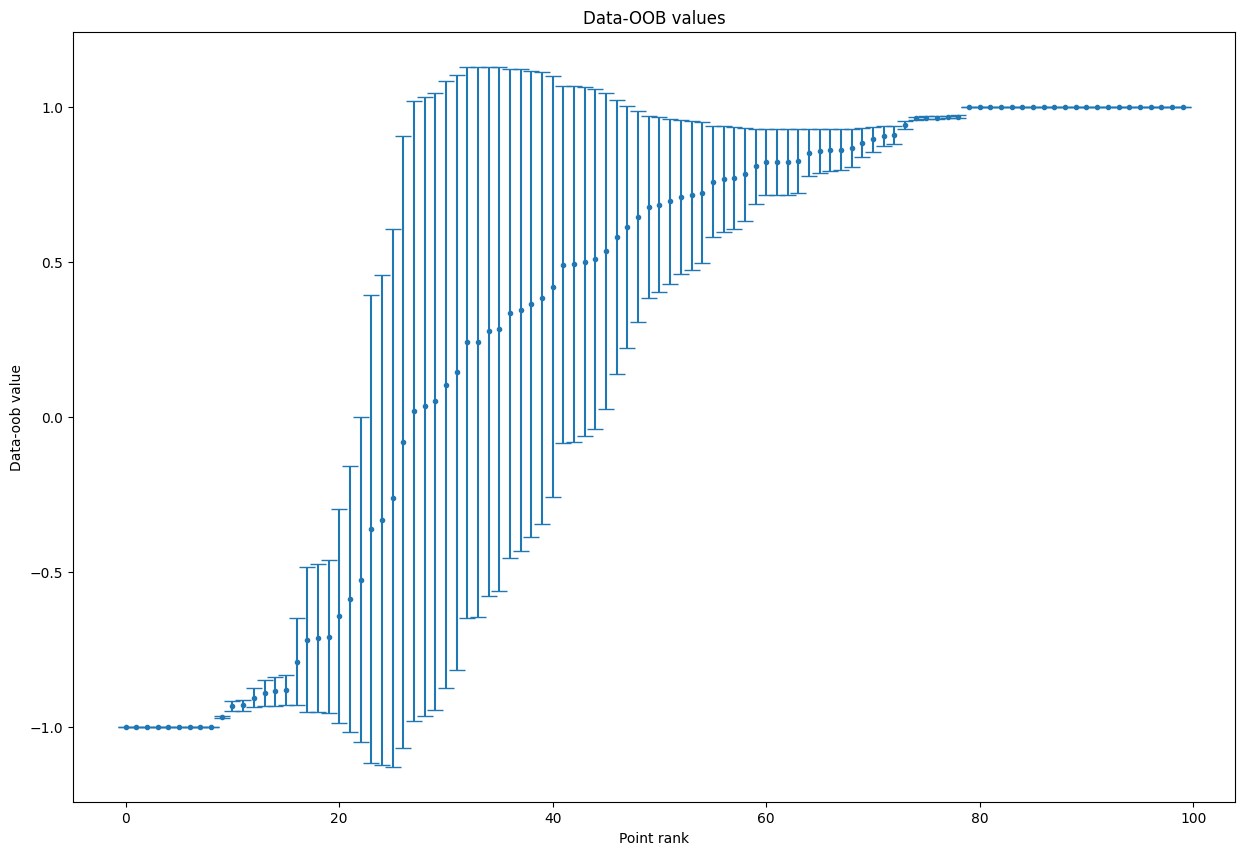

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 10])
ax.errorbar(
    x=np.arange(len(yerr)), y=[x[0] for x in plot_list], yerr=yerr, fmt=".", capsize=6
)
plt.title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

In [178]:
from pydvl.reporting.plots import compute_best_worst_scores, plot_best_worst_class_imbalance

In [119]:
def oob_func(utility, n_est):
    return(compute_data_oob_generative(utility, n_est=n_est, max_samples=0.4, progress=True))
n_est_list = [10, 20, 30]
func = oob_func
kwargs_list = [{"n_est":n_est} for n_est in n_est_list]

In [120]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

100%|██████████| 30/30 [00:05<00:00,  5.81it/s]


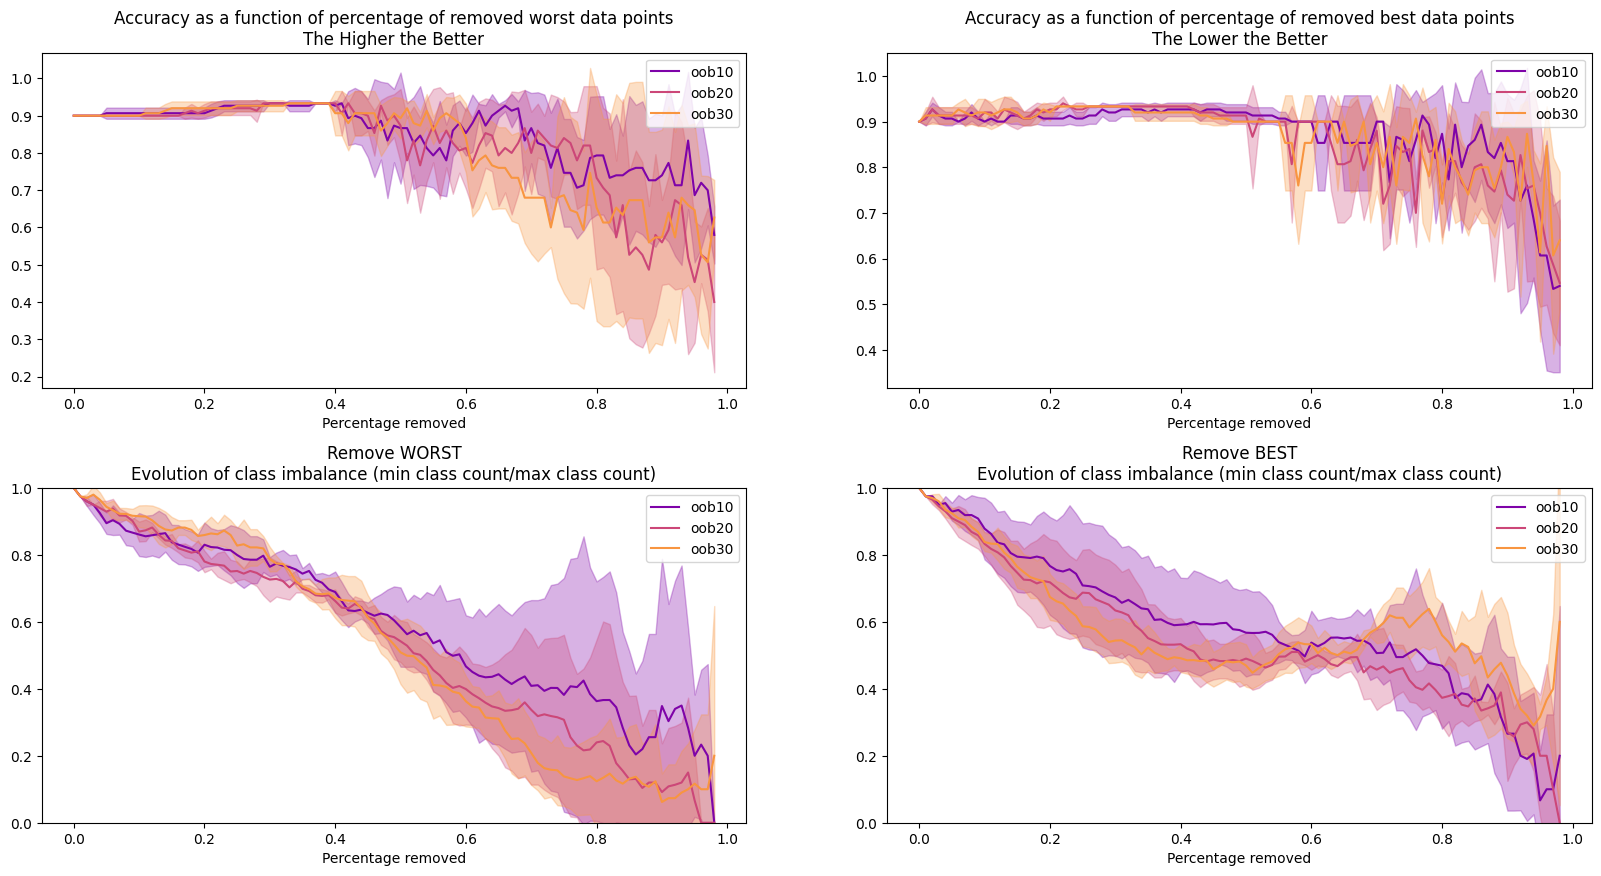

In [121]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility, palette_name="plasma")

In [29]:
! python3 -m pip install ctgan

In [38]:
real_data.shape

(32561, 15)

In [42]:
from sklearn.mixture import GaussianMixture

In [43]:
m = GaussianMixture()
m.fit(real_data)

ValueError: could not convert string to float: ' Private'

In [39]:
from ctgan import CTGAN, TVAE
from ctgan import load_demo

real_data = load_demo().sample(1000)

# Names of the columns that are discrete
discrete_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
]

#ctgan = CTGAN(epochs=10)
ctgan = TVAE()

ctgan.fit(real_data, discrete_columns)

# Create synthetic data
synthetic_data = ctgan.sample(1000)

/home/bastienzim/Documents/pyDVL_DataOOB/venv/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/bastienzim/Documents/pyDVL_DataOOB/venv/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/bastienzim/Documents/pyDVL_DataOOB/venv/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/bastienzim/Documents/pyDVL_DataOOB/venv/lib/python3.8/site-packages/rdt/transformers/

In [40]:
import copulas


In [41]:
from copulas.multivariate import gaussian

In [34]:
import ctgan

In [36]:
ctgan.TVAE

ctgan.synthesizers.tvae.TVAE